# <center> <h1> 🖱  👁  🧑‍💻 👁  🖱

# <center> Control the mouse through the eye
    
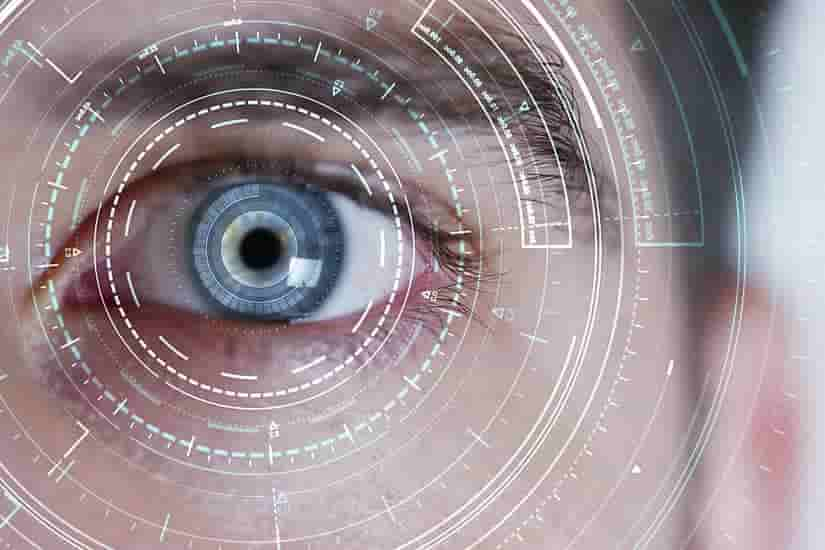

# <center> Required libraries

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, MaxPool2D, Conv2D
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3
import mediapipe as mp  # to work with points on the face
import pyautogui  # to control cursor movements
from PIL import Image 

# <center> First, we create a model and train it to detect whether an eye is open or closed.

In [2]:
train_data_dir = "Datasets/eye_close_open/train"
test_data_dir = "Datasets/eye_close_open/test"


## <center> <a href="https://drive.google.com/drive/folders/1LJzx1jSrmkb06WTeymEkR6C3EdVyD7td?usp=sharing">Link to dataset</a>


In [3]:
train_data = image_dataset_from_directory(train_data_dir, image_size=(224,224), batch_size=16)
test_data = image_dataset_from_directory(test_data_dir, image_size=(224,224), batch_size=16)

Found 81675 files belonging to 2 classes.
Found 3223 files belonging to 2 classes.


In [6]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [7]:
test_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
classes = train_data.class_names
classes

['close eyes', 'open eyes']

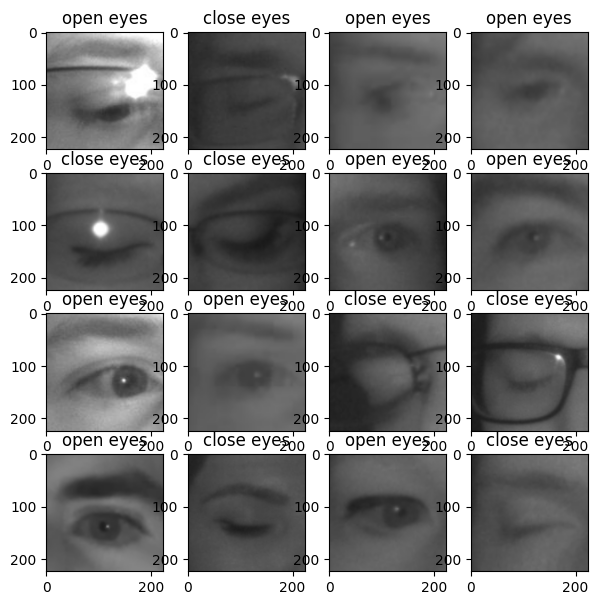

In [6]:
plt.figure(figsize=(7,7))
for rasm, label in train_data.take(1):
    
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.title(classes[label[i]])
        plt.imshow(rasm[i].numpy().astype("uint8"))

In [7]:
inception_v3 = InceptionV3(include_top=False, input_shape=(224,224,3))

In [8]:
for i in range(len(inception_v3.layers)):
    inception_v3.layers[i].trainable = False

In [9]:
new_model_inception_v3 = Sequential([
    inception_v3,
    Flatten(),
    #Dense(100, activation="relu"),
    Dense(2, activation="softmax")
])
# We have InceptionV3 model for 1000 classes so we are customizing it for 2 classes

In [10]:
new_model_inception_v3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 2)                 102402    
                                                                 
Total params: 21,905,186
Trainable params: 102,402
Non-trainable params: 21,802,784
_________________________________________________________________


In [11]:
new_model_inception_v3.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [14]:
with tf.device("/GPU:0"):
    new_model_inception_v3.fit(train_data, epochs=10)

Epoch 1/10
5105/5105 [==============================] - 1363s 264ms/step - loss: 0.4226 - accuracy: 0.9161
Epoch 2/10
5105/5105 [==============================] - 1684s 330ms/step - loss: 0.2242 - accuracy: 0.9538
Epoch 3/10
5105/5105 [==============================] - 1656s 324ms/step - loss: 0.1721 - accuracy: 0.9517
Epoch 4/10
5105/5105 [==============================] - 1085s 212ms/step - loss: 0.0907 - accuracy: 0.9716
Epoch 5/10
5105/5105 [==============================] - 1077s 211ms/step - loss: 0.0757 - accuracy: 0.9770
Epoch 6/10
5105/5105 [==============================] - 1074s 210ms/step - loss: 0.0973 - accuracy: 0.9731
Epoch 7/10
5105/5105 [==============================] - 1064s 208ms/step - loss: 0.0527 - accuracy: 0.9823
Epoch 8/10
5105/5105 [==============================] - 1065s 209ms/step - loss: 0.0382 - accuracy: 0.9872
Epoch 9/10
5105/5105 [==============================] - 1066s 209ms/step - loss: 0.0343 - accuracy: 0.9885
Epoch 10/10
5105/5105 [==============

In [15]:
new_model_inception_v3.evaluate(test_data)

202/202 [==============================] - 32s 92ms/step - loss: 0.1526 - accuracy: 0.9479


[0.152632936835289, 0.9478746652603149]

In [12]:
# new_model_inception_v3.save("Models/new_model_inception_v3_ev_94",save_format="h5")
# Save model

#### <center>  `Click on the link below and save the model we taught above.`

<center> <a href="https://drive.google.com/file/d/1X_N0CeuC1QxNoVURJ4PGC2RrmhQN6tff/view?usp=sharing">new_model_inception_v3.h5</a>

In [13]:
#new_model_inception_v3 = tf.keras.models.load_model('Models/new_model_inception_v3_ev_94.h5')
# you enter the code above to use the downloaded model

## <center> Now let's see how the mediapipe library works. Mediapipe is a cross-platform framework created by Google for machine learning. We use its FaceMash function to find points on the face.

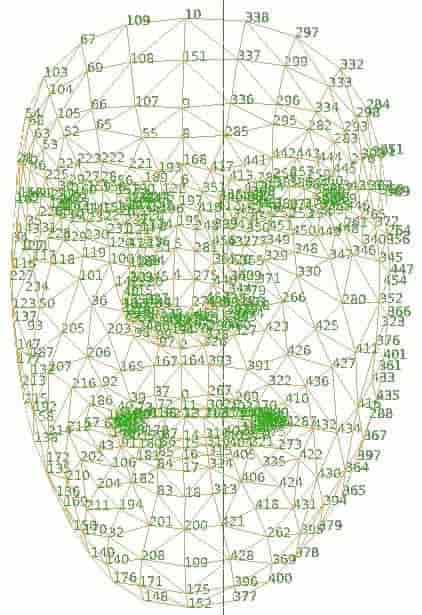

In [14]:
cam = cv2.VideoCapture(0) # We will connect our camera
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)  # FaceMesh is part of the mediapipe framework.

while True:
    
    _, frame = cam.read()
    frame = cv2.flip(frame, 1) # this code will fix the camera
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # we convert each frame to rgb
    output = face_mesh.process(rgb_frame)     # we give rgb image to facemash
    landmark_points = output.multi_face_landmarks # and from it we get landmarks, that is, the necessary points
    frame_h, frame_w, _ = frame.shape # The size of the frame is what we need to place the dots correctly
    #print(landmark_points)
    
    if landmark_points:
        landmarks = landmark_points[0].landmark # 
        
             
        for landmark in landmarks:
            x = int(landmark.x * frame_w)  # the x-axis value of the desired point
            y = int(landmark.y * frame_h)  # the y-axis value of the desired point
            cv2.circle(frame, (x,y), 2, (0,255,0))  # we mark the necessary points with a circle
    
    cv2.imshow("Landmarks", frame)
    
     
    if cv2.waitKey(1) & 0xFF==ord("q"):
        break
        
cam.release()
cv2.destroyAllWindows()

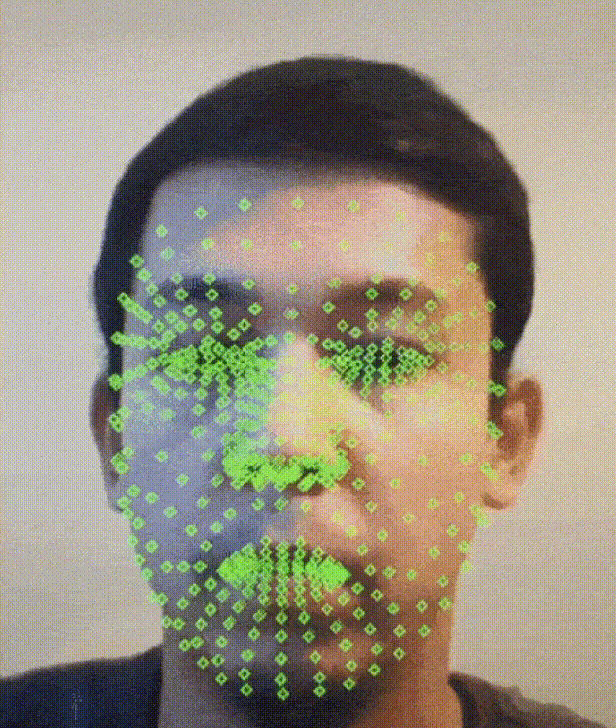

## <center> We don't need all the dots, we just need the dots for the left and right eye. We control the cursor with the left eye and click with the right eye.

In [15]:
x1,x2,y1,y2 = 0,0,0,0
# initial values for our rectangle

In [16]:
cam = cv2.VideoCapture(0)
face_mesh = mp.solutions.face_mesh.FaceMesh(refine_landmarks=True)  # FaceMesh is a feature of the mediapipe framework.
screen_w, screen_h = pyautogui.size()
s=0
while True:
    
    _, frame = cam.read()
    frame = cv2.flip(frame, 1)
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    output = face_mesh.process(rgb_frame)
    landmark_points = output.multi_face_landmarks
    frame_h, frame_w, _ = frame.shape
    #print(landmark_points)
    
    if landmark_points:
        landmarks = landmark_points[0].landmark
        

        for idi, landmark in enumerate(landmarks[23:31]):  # 23:31 points of the left eye
            x = int(landmark.x * frame_w)
            y = int(landmark.y * frame_h)
            cv2.circle(frame, (x,y), 3, (0,255,255))
            #print(x,y)
            
            if idi==1:
                screen_x = screen_w / frame_w * x
                screen_y = screen_h / frame_h * y
                pyautogui.moveTo(screen_x,screen_y) # move the mouse
        
             
        for landmark in landmarks[474:477]:  # the left upper point of the right eye
            x1 = int(landmark.x * frame_w)
            y1 = int(landmark.y * frame_h)       
        
        for landmark in landmarks[474:478]:   # the right lower point of the right eye
            x2 = int(landmark.x * frame_w)
            y2 = int(landmark.y * frame_h)
            
        
        if s%5==0:  # if we send each frame to the model for prediction, our camera freezes. 
                    # Therefore, we send every five frames to the model, if our camera takes 30 frames in 1 second,
                    # we make 6 predictions in 1 second. This will help prevent constipation, even if only a little
                    
            
            img = Image.fromarray(rgb_frame)

            box = (x1-20, y1-20, x2+20, y2+20) #we cut the mesh through the points x1,y1, x2,y2. Because we only need the right eye for prophecy
            img2 = img.crop(box)
            img3 = np.array(img2)
    
            img3 = cv2.resize(img3, (224,224)) # We will change the image of our cropped eye to 224x224, 
                                               # because we trained the image as 224x224 when training the model,
                                               # now we will give it the same size during prediction.
                                               

    
            img3 = np.expand_dims(img3,  axis=0)
    
            predict = new_model_inception_v3.predict(img3) # predicts whether our eyes are open or closed
            
    
            sinf = np.argmax(predict)
        #sinfi = ""
        #if sinf==0:
        #    sinfi = "Yopiq"
        #else:
        #    sinfi = "Ochiq"
        
            
            if sinf==0:        # so class = 0, that is, if our eyes are closed, click works
                print("click")
                pyautogui.click()
                pyautogui.sleep(1)
            
    
    cv2.rectangle(frame, (x1-20,y1-20), (x2+30, y2+10),(0,255,0),1)  # draw a rectangle on the right eye
    
    cv2.imshow("Eye controlled Mouse", frame)
    
    #cv2.waitKey(1)
      
    s+=1
     
    if cv2.waitKey(1) & 0xFF==ord("q"):
        break
        
cam.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 32ms/step
click
1/1 [==============================] - 0s 32ms/step
click
1/1 [==============================] - 0s 32ms/step
click
1/1 [==============================] - 0s 31ms/step
click
1/1 [==============================] - 0s 32ms/step
click
1/1 [==============================] - 0s 36ms/step
click
1/1 [==============================] - 0s 32ms/step
click


In [9]:
cam.release()
cv2.destroyAllWindows()

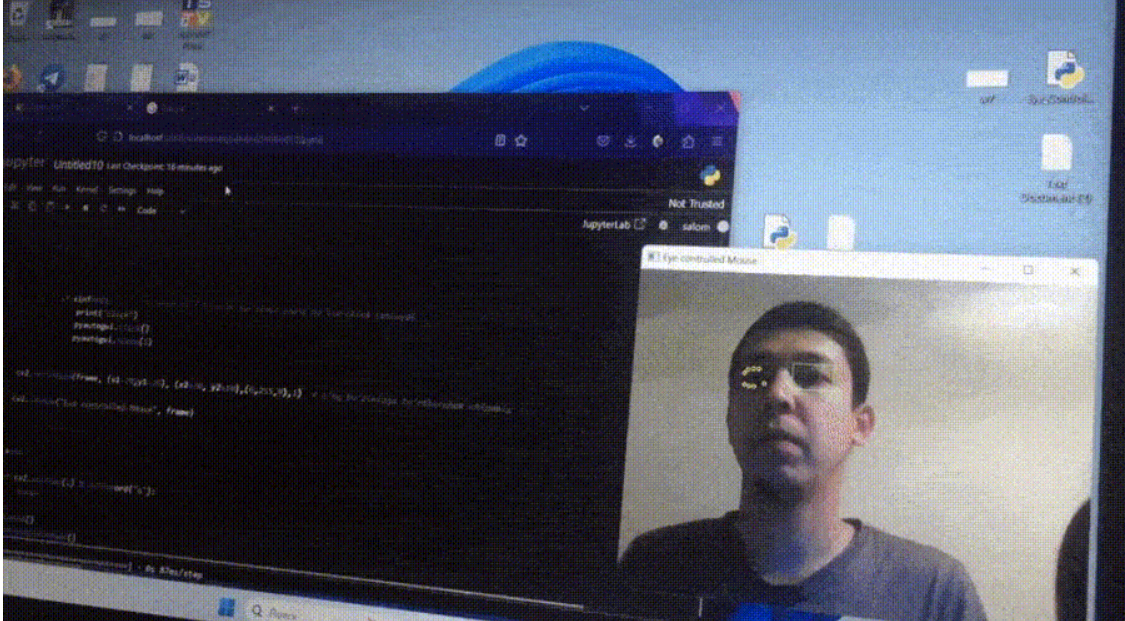

#### <center>  `Follow the link below to watch the video above in full.`

<center> <a href="https://drive.google.com/file/d/1XVFIgStm3mGYuVXJcT4sgKRM3pNYR5iY/view?usp=sharing">Click here to watch the video above in full.</a>

# <center> <h1> 👨‍💻   🚀  